# Pennylane : Sequential Circuit Structure
This notebook shows the expansion of Pennylane to build sequential circuits. <br>
The specific expansion is the use of python classes to streamline the way that <br>
Quantum Variational Circuits are constructed to fit common Deep Learning framework <br> architectures.

In [96]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates.embeddings import AmplitudeEmbedding, AngleEmbedding
from model import Conv1DLayer, PoolingLayer, unitarity_conv1d, unitarity_pool, unitarity_toffoli

# Defining the device

In [103]:
#Specify how many wires will be used
num_wires = 12
num_ancilla = 4
num_work_wires = num_wires - num_ancilla

#Specify what type of device you are using.
#device_type = 'default.qubit'
device_type = 'lightning.qubit'

#Initialize Device
dev = qml.device(device_type, wires=num_wires)

# Defining the sequential circuit

In [104]:
def circuit(num_wires, num_ancilla):
    @qml.qnode(dev, interface='torch', diff_method ='adjoint')
    def func(inputs, params): 
        work_wires = list(range(num_wires - num_ancilla))
        ancilla_wires = list(range(len(work_wires),num_wires))

        # Data Embedding Layer
        AmplitudeEmbedding(inputs , wires=work_wires , normalize=True)

        # Hidden Layers
        work_wires , params = Conv1DLayer(unitarity_conv1d , 15)(work_wires , params)
        work_wires , params = PoolingLayer(unitarity_pool , 2)(work_wires , params)
        work_wires , params = Conv1DLayer(unitarity_conv1d , 15)(work_wires , params)
        work_wires , params = PoolingLayer(unitarity_pool , 2)(work_wires , params)

        #Toffili Structure
        unitarity_toffoli(work_wires,ancilla_wires)


        return [qml.expval(qml.PauliZ(wire)) for wire in ancilla_wires]
    return func

## Visualizing the circuit

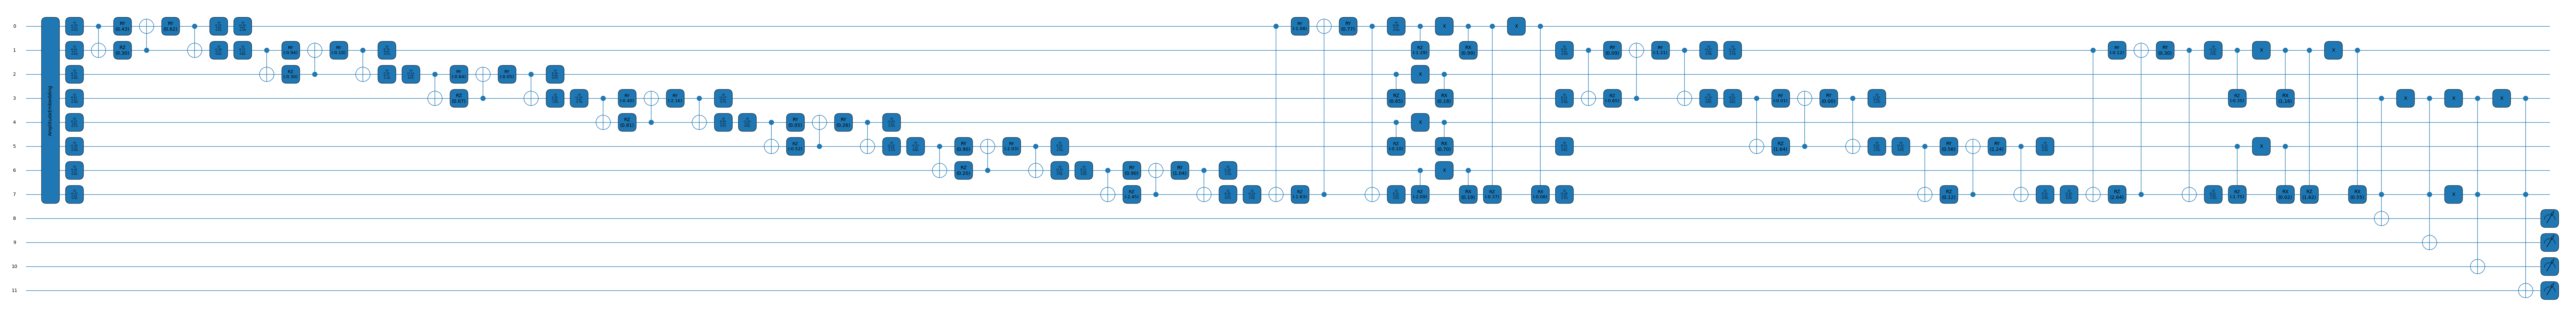

In [105]:
# x is the encoded date sized to an array of x length, where x = 2^qubits.
embedding_size = 2**num_work_wires
dummy_embedding = [1] * embedding_size

# Initializing parameters, this based off the unitarity, and model structure. 
params = np.random.normal(loc=0.0, scale=1.0, size = 198)

from matplotlib import pyplot as plt
fig, ax = qml.draw_mpl(circuit(num_wires, num_ancilla), decimals=2)(dummy_embedding, params)
plt.show()